In [2]:
import numpy as np
from matplotlib import pyplot as plt
import random
import gudhi as gd
import itertools

import tadasets
from datetime import datetime

import ecc_gudhi
import ecc_recursive
import ecc_sequential
import ecc_sequential_CPP
import compute_local_EC
import ecc_utils

In [3]:
# https://anaconda.org/conda-forge/memory_profiler
%load_ext memory_profiler

In [4]:
%load_ext line_profiler

### NOTE: the ECC plot obtained via ecc_recursive contains more points that the one obtained from ecc_gudhi because ecc_gudhi only outputs the points in wich the EC changes values and discards thoose when the sum of the contributions equals 0

In [2]:
def compare_methods(points, epsilon, draw_lines=True):
    # ECC
    print("Star of the simplex - GUDHI")
    start=datetime.now()
    c_ls, ns_ls = ecc_gudhi.compute_local_contributions(points, epsilon)
    print("\t time:", datetime.now()-start)
     
    e_ls = ecc_utils.euler_characteristic_list_from_all(c_ls)
    print("\t simplicies found:          ", ns_ls)
    print("\t points in the ecc plot:    ", len(e_ls))
    
    ecc_utils.plot_euler_curve(e_ls, draw_lines, "Star of the simplex - GUDHI")
    
#     # extend cliques recursively
#     print("\nExtend cliques recursively - pure python")
#     start=datetime.now()
#     c = ecc_recursive.compute_local_contributions(points, epsilon)
#     print("\t time:", datetime.now()-start)
#     # the number of simplicies is equal to contributions list lenght
#     print("\t simplicies found:          ", len(c))
    
#     e_cc = ecc_utils.euler_characteristic_list_from_all(c)
#     reduced_ecc = [e_cc[0]]
#     for i, point in enumerate(e_cc[1:]):
#         if point[1] != e_cc[i][1]:
#             reduced_ecc.append(point)
#     print("\t points in the ecc plot:    ", len(reduced_ecc))
    
#     ecc_utils.plot_euler_curve(reduced_ecc, draw_lines, "Extend cliques recursively - pure python")
    
#     # extend cliques sequentially
#     print("\nExtend cliques sequentially - pure python")
#     start=datetime.now()
#     c_seq, ns_seq = ecc_sequential.compute_local_contributions(points, epsilon)
#     print("\t time:", datetime.now()-start)
#     print("\t simplicies found:          ", ns_seq)
    
#     e_seq = ecc_utils.euler_characteristic_list_from_all(c_seq)
#     print("\t points in the ecc plot:    ", len(e_seq))
    
#     ecc_utils.plot_euler_curve(e_seq, draw_lines, "Extend cliques sequentially - pure python")
    
    
    # extend cliques sequentially CPP
    print("\nExtend cliques sequentially - CPP")
    start=datetime.now()
    c_cpp, ns_cpp = ecc_sequential_CPP.compute_local_contributions(points, epsilon)
    print("\t time:", datetime.now()-start)
    print("\t simplicies found:          ", ns_cpp)
    
    e_cpp = ecc_utils.euler_characteristic_list_from_all(c_cpp)
    print("\t points in the ecc plot:    ", len(e_cpp))
    
    ecc_utils.plot_euler_curve(e_cpp, draw_lines, "Extend cliques sequentially - CPP")
    
    print('')
    print('Consistency tests')
    print('Number of simplices: {}'.format(ns_ls==ns_cpp))
    print('ECC consistence    : {}'.format(e_ls==e_cpp))

## Triangle

In [ ]:
point_cloud = np.array([[0, 0], [4,0], [0,3] ])

In [ ]:
plt.scatter(point_cloud[: , 0], point_cloud[: , 1])

In [ ]:
compare_methods(point_cloud, 10)

## Rhomboid

In [18]:
def compute_ECC_from_simplextree(st):
    local_contributions = {} # dict {filtration: contribution}

    simplex_counter = 0

    for simplex, filtration in st.get_filtration():
        contribution = (-1)**(len(simplex)-1) # len(simplex) - 1 = dimension of the simplex
        # store the contribution at the right filtration value
        local_contributions[filtration] = local_contributions.get(filtration, 0) + contribution

        simplex_counter += 1

    # remove the contributions that are 0
    to_del = []
    for key in local_contributions:
        if local_contributions[key] == 0:
            to_del.append(key)

    for key in to_del:
        del local_contributions[key]

    # convert the dict into a list, sort it according to the filtration and return it
    return sorted(list(local_contributions.items()), key = lambda x: x[0]), simplex_counter

In [19]:
epsilon = 10

point_cloud_1 = np.array([[4,0], [0,3.5], [-2, 0], [-0.5, -3]])

rips_complex_1 = gd.RipsComplex(points=point_cloud_1, max_edge_length=epsilon)
simplex_tree_1 = rips_complex_1.create_simplex_tree(max_dimension=len(point_cloud_1)-1)

for s in simplex_tree_1.get_filtration():
    print(s)

([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([2, 3], 3.3541019662496847)
([1, 2], 4.031128874149275)
([0, 1], 5.315072906367325)
([0, 3], 5.408326913195984)
([0, 2], 6.0)
([0, 1, 2], 6.0)
([0, 2, 3], 6.0)
([1, 3], 6.519202405202649)
([0, 1, 3], 6.519202405202649)
([1, 2, 3], 6.519202405202649)
([0, 1, 2, 3], 6.519202405202649)


In [20]:
simplex_tree_2 = gd.SimplexTree()

for s in simplex_tree_1.get_filtration():
    f = s[1]
    if len(s[0]) > 1:
        f += 0.2
    simplex_tree_2.insert(s[0], filtration=f)
    
for s in simplex_tree_2.get_filtration():
    print(s)

([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([2, 3], 3.554101966249685)
([1, 2], 4.231128874149275)
([0, 1], 5.515072906367325)
([0, 3], 5.6083269131959845)
([0, 2], 6.2)
([0, 1, 2], 6.2)
([0, 2, 3], 6.2)
([1, 3], 6.719202405202649)
([0, 1, 3], 6.719202405202649)
([1, 2, 3], 6.719202405202649)
([0, 1, 2, 3], 6.719202405202649)


NameError: name 'point_cloud' is not defined

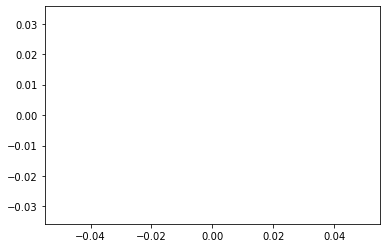

In [21]:
plt.axis('equal')
labels = ["A", "B", "C", "D"]
for i in range(len(point_cloud_1)):
    plt.scatter(point_cloud_1[i][0], point_cloud_1[i][1], color = "red")
    plt.text(point_cloud_1[i][0], point_cloud_1[i][1], labels[i], fontsize =15)


In [ ]:
c_cpp, ns_cpp = compute_ECC_from_simplextree(simplex_tree_1)
print("\t simplicies found:          ", ns_cpp)

e_cpp = ecc_utils.euler_characteristic_list_from_all(c_cpp)
print("\t points in the ecc plot:    ", len(e_cpp))

ecc_utils.plot_euler_curve(e_cpp, True, "Extend cliques sequentially - CPP")

In [ ]:
#compare_methods(point_cloud, 10)

## Tetrahedron

In [ ]:
point_cloud = np.array([[0,0,0], [0,1,0], [2,0,0], [0,0,3]])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([x[0] for x in point_cloud], [x[1] for x in point_cloud], [x[2] for x in point_cloud])

In [ ]:
compare_methods(point_cloud, 10)

## Points from the example in the slides



In [4]:
point_cloud = np.array([[0,0], [2,-0.2], [4,0.2], [0,-1.5], [2,-3], [4,-1], [3.8,-2.5]] )

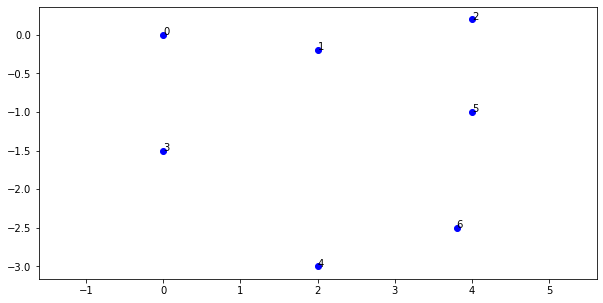

In [5]:
plt.figure(figsize=(10,5))
plt.axis('equal')
for i in range(len(point_cloud)):
    plt.scatter(point_cloud[i][0], point_cloud[i][1], color = "blue")
    plt.text(point_cloud[i][0], point_cloud[i][1], i)

In [6]:
compare_methods(point_cloud, 10)

NameError: name 'compare_methods' is not defined

	 simplicies found:           127
[[0, 7], [1.2, 6], [1.5, 5], [1.5132745950421556, 4], [1.8681541692269403, 3], [2.009975124224178, 2], [2.039607805437114, 1], [2.5, 0], [2.8284271247461903, 1]]


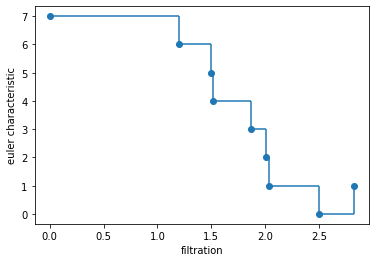

In [8]:
c_cpp, ns_cpp = ecc_sequential_CPP.compute_local_contributions(point_cloud, 10)
print("\t simplicies found:          ", ns_cpp)
    
e_cpp = ecc_plot.euler_characteristic_list_from_all(c_cpp)

print(e_cpp)
ecc_plot.plot_euler_curve(e_cpp, True)

	 simplicies found:           127
[[0, 7], [1.5, 5], [2.0, 4], [2.009975124224178, 3], [2.0615528128088303, 2], [2.154065922853802, 1], [2.5, 0], [2.8284271247461903, 1]]


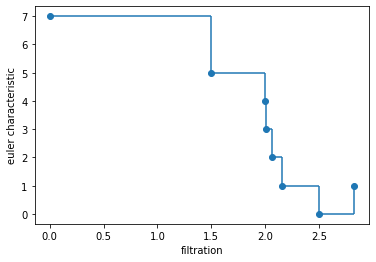

In [9]:
point_cloud_2 = np.array([[0,0], [2,-0.2], [4,1], [0,-1.5], [2,-3], [4,-1], [4,-2.5]] )
c_cpp2, ns_cpp2 = ecc_sequential_CPP.compute_local_contributions(point_cloud_2, 10)
print("\t simplicies found:          ", ns_cpp2)
    
e_cpp2 = ecc_plot.euler_characteristic_list_from_all(c_cpp2)
print(e_cpp2)
ecc_plot.plot_euler_curve(e_cpp2, True)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Circle

In [ ]:
point_cloud = []

NUMBER_OF_POINTS = 100

random.seed(42)
for i in range(NUMBER_OF_POINTS):
    angle = random.uniform(0,2*np.pi)
    point_cloud.append([np.cos(angle), np.sin(angle)])
    
point_cloud = np.array(point_cloud)

#np.savetxt('circle.csv', point_cloud, fmt='%f', delimiter=',')

In [ ]:
plt.axis('scaled')
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.scatter(point_cloud[:,0], point_cloud[:,1])

In [ ]:
points = point_cloud
epsilon = 1
draw_lines = False

In [ ]:
compare_methods(point_cloud, epsilon, draw_lines)

### we can use memory_profiler to monitor the RAM usage

In [ ]:
%memit ecc_gudhi.compute_local_contributions(points, epsilon)

In [ ]:
#%memit ecc_recursive.compute_local_contributions(points, epsilon)

In [ ]:
#%memit ecc_sequential.compute_local_contributions(points, epsilon)

In [ ]:
%memit ecc_sequential_CPP.compute_local_contributions(points, epsilon)

In [ ]:
%lprun -f compute_local_contributions compute_local_contributions(points, epsilon)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [ ]:
import compute_local_EC

def create_local_graph(points, i, threshold, dbg=False):
    center_vertex = points[i]

    # enumeration needs to start from i+1 because the center is at position i
    id_neigs_of_center_vectex = [j for j,point in enumerate(points[i+1:], i+1) 
                                 if np.linalg.norm(center_vertex - point) <= threshold]
    
    if dbg: print(id_neigs_of_center_vectex)
       
    # create the center graph as a list of lists
    # each list corespond to a node and contains its neighbours with distance
    # note, edges are always of the type
    # (i, j) with i<j in the ordering. 
    # This is to save space, we do not need the edge (j, i) 
    # In practice, we are building onlty the upper triangular part
    # of the adjecency matrix
    
    considered_graph = []
    
    # add central vertex
    mapped_center_vertex = []
    # enumeration needs to start from 1 because 0 is the center
    for j, neigh in enumerate(id_neigs_of_center_vectex, 1):
        mapped_center_vertex.append( (j, np.linalg.norm(center_vertex - points[neigh])) )
        
    considered_graph.append(mapped_center_vertex)
    
    # add the rest
    for j, neigh in enumerate(id_neigs_of_center_vectex, 1):
        
        if dbg: print(j, neigh)
        
        neighbours_of_j = []
        
        # add the others
        # note that the index k starts from 1, be careful with the indexing
        for z, other_neigh in enumerate(id_neigs_of_center_vectex[j:], j+1):
            if dbg: print('    ', z, other_neigh)
            dist = np.linalg.norm(points[neigh] - points[other_neigh])
            if (dist <= threshold):
                neighbours_of_j.append( (z, dist) )
        
        considered_graph.append(neighbours_of_j)
              
    return considered_graph



def compute_local_contributions(point_cloud, epsilon):
    # for each point, create its local graph and find all the
    # simplices in its star
    
    ECC_list = []
    total_number_of_simplices = 0

    for i in range(len(point_cloud)):
        graph_i = create_local_graph(point_cloud, i, epsilon)
        local_ECC, number_of_simplices = compute_local_EC.compute_local_EC(graph_i, False)
        ECC_list.append(local_ECC)
        total_number_of_simplices += number_of_simplices

    total_ECC = dict()

    for single_ECC in ECC_list:
        for key in single_ECC:
            total_ECC[key] = total_ECC.get(key, 0) + single_ECC[key]

    # remove the contributions that are 0
    to_del = []
    for key in total_ECC:
        if total_ECC[key] == 0:
            to_del.append(key)
    for key in to_del:
        del total_ECC[key]
        
    return sorted(list(total_ECC.items()), key = lambda x: x[0]) , total_number_of_simplices

## Double circle

In [ ]:
point_cloud = []

NUMBER_OF_POINTS = 100

random.seed(42)
for i in range(NUMBER_OF_POINTS):
    angle = random.uniform(0,2*np.pi)
    point_cloud.append([np.cos(angle), np.sin(angle)])
    
    angle = random.uniform(0,2*np.pi)
    point_cloud.append([2*np.cos(angle), 5*np.sin(angle)])
    
    
point_cloud = np.array(point_cloud)

In [ ]:
plt.axis('scaled')
plt.xlim((-2.2,2.2))
plt.ylim((-2.2,2.2))
plt.scatter(point_cloud[:, 0], point_cloud[:, 1])

In [ ]:
compare_methods(point_cloud, 0.75, draw_lines=False)

In [ ]:
compare_methods(point_cloud, 1, draw_lines=False)

In [ ]:
%%time
ecc_gudhi.compute_local_contributions(point_cloud, 1)

In [ ]:
%memit ecc_gudhi.compute_local_contributions(point_cloud, 1)

In [ ]:
%%time
%memit ecc_sequential_CPP.compute_local_contributions(point_cloud, 1)

In [ ]:
%memit ecc_sequential_CPP.compute_local_contributions(point_cloud, 1)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# infinity

In [ ]:
point_cloud = tadasets.infty_sign(n=50, noise=None)

np.savetxt('infinity.csv', point_cloud, fmt='%f', delimiter=',')

In [ ]:
#plt.axis('scaled')
plt.scatter(point_cloud[:, 0], point_cloud[:, 1])

In [ ]:
compare_methods(point_cloud, 1)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# n shpere

In [ ]:
point_cloud = tadasets.sphere(n=100, r=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])

np.savetxt('sphere.csv', point_cloud, fmt='%f', delimiter=',')

In [ ]:
compare_methods(point_cloud, .5, draw_lines=False)

# torus

In [ ]:
point_cloud = tadasets.torus(n=100, c=2, a=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])

np.savetxt('torus.csv', point_cloud, fmt='%f', delimiter=',')

## Hypercube

In [ ]:
# random points in the unit cube

N_POINTS = 100
DIMENSION = 3

np.random.seed(42)
point_cloud = np.random.rand(N_POINTS,DIMENSION)

In [ ]:
compare_methods(point_cloud, 0.6, draw_lines=False)

# GRID

In [ ]:
def create_grid(dim, lenght):
    # creates #dim arrays each of #lenght numbers at 0.1 distance
    # then staks them together

    return np.stack(np.meshgrid( *[[x/10 for x in range(lenght)] for i in range(dim)]  ), -1).reshape(-1, dim)

In [ ]:
point_cloud = create_grid(4, 5)

In [ ]:
compare_methods(point_cloud, 0.2)

In [4]:
import pandas as pd

In [5]:
data = pd.read_csv('sphere4_50000.csv', header=None)
data.shape

(50000, 5)

In [6]:
data

,0,1,2,3,4
0,-0.820170,-0.188449,0.380198,0.123469,0.363335
1,0.283410,-0.237443,0.694543,0.319030,0.528327
2,0.637184,0.484025,-0.089570,0.500890,0.317494
3,-0.110611,0.869256,0.316739,0.024393,-0.362272
4,0.009451,0.531955,-0.035801,-0.843016,0.070547
...,...,...,...,...,...
49995,-0.453727,0.475084,0.493069,-0.271264,-0.501723
49996,-0.095990,-0.088713,0.267022,-0.779237,0.551729
49997,0.573412,-0.431368,-0.122464,-0.685246,0.023705
49998,0.214890,-0.423452,-0.233990,-0.071456,0.845372


In [ ]:
compare_methods(data.values, 0.28, draw_lines=False)

In [ ]:
%memit ecc_gudhi.compute_local_contributions(data.values, 0.28)

In [10]:
%%time
a, b = ecc_sequential_CPP.compute_local_contributions(data.values, 0.28)
print(b)

946072121
CPU times: user 11h 9min 33s, sys: 5min 46s, total: 11h 15min 19s
Wall time: 12h 2min 8s


In [7]:
%memit ecc_sequential_CPP.compute_local_contributions(data.values, 0.28)

peak memory: 821.23 MiB, increment: 720.93 MiB
